### Load models


In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import rc

sys.path.append("../")
# Import dataloaders
import data_utils.ood_detection.cifar10 as cifar10
import data_utils.ood_detection.cifar100 as cifar100
import data_utils.ood_detection.lsun as lsun
import data_utils.ood_detection.svhn as svhn
import data_utils.ood_detection.mnist as mnist
import data_utils.ood_detection.tiny_imagenet as tiny_imagenet

# Network architectures
from net.lenet import lenet
from net.resnet import resnet50
from net.vgg import vgg16
from net.wide_resnet import wrn

from utils.gmm_utils import get_embeddings, gmm_evaluate, gmm_fit, maxp_evaluate, gmm_evaluate_with_perturbation, maxp_evaluate_with_perturbation
from metrics.uncertainty_confidence import entropy, logsumexp, confidence, sumexp, max

In [27]:
device = torch.device("cuda:1")
# Dataset params
dataset_num_classes = {"cifar10": 10, "cifar100": 100, "svhn": 10, "lsun": 10, "tiny_iamgenet": 200}

dataset_loader = {"cifar10": cifar10, "cifar100": cifar100, "svhn": svhn, "mnist": mnist, "lsun": lsun, "tiny_imagenet": tiny_imagenet}

# Mapping model name to model function
models = {
    "lenet": lenet,
    "resnet50": resnet50,
    "wide_resnet": wrn,
    "vgg16": vgg16,
}

model_to_num_dim = {"resnet18": 512, "resnet50": 2048, "resnet101": 2048, "resnet152": 2048, "wide_resnet": 640, "vgg16": 512}

batch_size = 256
dataset = "cifar10"
ood_dataset = "svhn"
dataset_root = "../data"
# model = "vgg16"
# saved_model_name = "../saved_models/run13/vgg16_sn_3.0_mod_seed_1/2024_04_22_23_23_06/vgg16_sn_3.0_mod_seed_1_best.model"

model = "resnet50"
saved_model_name = "../saved_models/run17/resnet50_sn_3.0_mod_seed_1/2024_05_21_12_30_21/resnet50_sn_3.0_mod_seed_1_best.model"
# Taking input for the dataset
num_classes = dataset_num_classes[dataset]
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=batch_size)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=batch_size)

Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032


In [28]:
train_loader, val_loader = dataset_loader[dataset].get_train_valid_loader(
    root=dataset_root,
    batch_size=batch_size,
    augment=True,
    val_seed=1,
    val_size=0.1,
)

#load model
print(f"load {saved_model_name}")
net = models[model](
    spectral_normalization=True,
    mod=True,
    num_classes=num_classes,
    temp=1.0,
).to(device)

net.load_state_dict(torch.load(str(saved_model_name), map_location=device), strict=True)

load ../saved_models/run17/resnet50_sn_3.0_mod_seed_1/2024_05_21_12_30_21/resnet50_sn_3.0_mod_seed_1_best.model


<All keys matched successfully>

In [29]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 2.5})

rc('text', usetex=False)


def plot_density(results, binrange, bins, title, xlabel):

    plt.figure(figsize=(5, 3))
    plt.tight_layout()

    plt.hist(results[0], density=True, color='r', range=binrange, bins=bins, alpha=0.5, label="org")
    plt.hist(results[1], density=True, color='b', range=binrange, bins=bins, alpha=0.5, label="ood")

    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Fraction', fontsize=12)
    plt.title(label=title)
    plt.legend()


if not os.path.exists("pngs"):
    os.makedirs("pngs")

In [30]:
embeddings, labels,norm = get_embeddings(
    net,
    train_loader,
    num_dim=model_to_num_dim[model],
    dtype=torch.double,
    device=device,
    storage_device=device,
)
gaussians_model, jitter_eps = gmm_fit(embeddings=embeddings, labels=labels, num_classes=num_classes)

get embeddings from dataloader...


100%|██████████| 176/176 [00:49<00:00,  3.58it/s]


norm threshold:0.1694011092185974


In [34]:
def calculate_gradients(
    net,
    gaussians_model,
    loader,
    device,
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010],
    norm = 1,
):
    num_samples = len(loader.dataset)
    norms = torch.empty(num_samples, dtype=torch.float)

    std = torch.tensor(std).to(device)
    mean = torch.tensor(mean).to(device)
    loss_func = nn.CrossEntropyLoss()
    start = 0
    for data, label in tqdm(loader,dynamic_ncols=True):
        data = data.to(device)
        label = label.to(device)
        
        data.requires_grad = True  #data.required_grad区分,用required_grad梯度为None
        out = net(data)
        uniform = torch.ones_like(out).to(device)
        _, pred = torch.max(out, 1)

        # #1. 第一种形式loss
        embedding = net.feature
        log_probs = gaussians_model.log_prob(embedding[:, None, :])
        max_log_probs = log_probs.max(1, keepdim=True)[0]  # get the index of the max log-probability
        loss = max_log_probs.sum()

        # # #2. 第二种形式loss
        # loss = -loss_func(out, pred)

        ###3.第三种loss
        # loss = F.kl_div(out.softmax(dim=-1).log(),uniform.softmax(dim=-1), reduction='sum')

        net.zero_grad()
        loss.backward()

        # Normalizing the gradient to binary in {0, 1}
        gradient = data.grad.data

        gradient_norms = torch.norm(gradient, p=norm, dim=(1, 2, 3))
        # gradient_norms = torch.linalg.matrix_norm(gradient,ord=norm,dim=(2,3)).sum(dim=1)
        end = start + len(data)
        norms[start:end].copy_(gradient_norms.cpu().detach(), non_blocking=True)
        start = end

    return norms

In [35]:
gradient_norms = calculate_gradients(
    net,
    gaussians_model,
    test_loader,
    device=device,
    norm=1,
)
ood_gradient_norms = calculate_gradients(
    net,
    gaussians_model,
    ood_test_loader,
    device=device,
    norm=1.
)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:13<00:00,  3.00it/s]


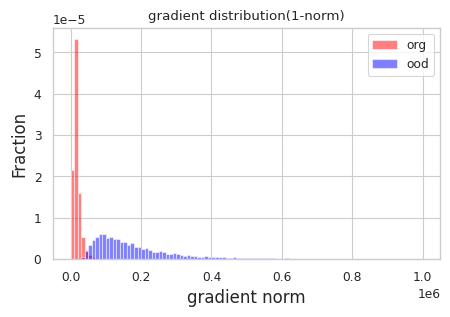

In [38]:
plot_density([gradient_norms.numpy(), ood_gradient_norms.numpy()], binrange=[0, 1000000], bins=100, title="gradient distribution(1-norm)", xlabel="gradient norm")
plt.savefig('pngs/grad_dist.png', bbox_inches='tight')

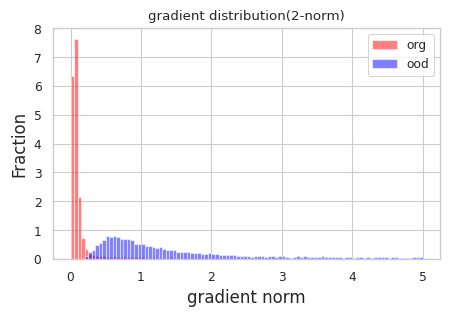

In [25]:
plot_density([gradient_norms.numpy(), ood_gradient_norms.numpy()], binrange=[0, 5], bins=100, title="gradient distribution(2-norm)", xlabel="gradient norm")
plt.savefig('pngs/grad_dist.png', bbox_inches='tight')

### Compute logits


In [10]:
logits, _ = maxp_evaluate(net, test_loader, device, num_classes, storage_device=device)
ood_logits, _ = maxp_evaluate(net, ood_test_loader, device, num_classes, storage_device=device)
logits2, _ = maxp_evaluate_with_perturbation(net, test_loader, device, num_classes, storage_device=device)
ood_logits2, _ = maxp_evaluate_with_perturbation(net, ood_test_loader, device, num_classes, storage_device=device)

100%|██████████| 79/79 [00:20<00:00,  3.92it/s]


In [42]:
probs = torch.max(torch.softmax(logits, dim=1), axis=1)[0].cpu().numpy()
probs2 = torch.max(torch.softmax(logits2, dim=1), axis=1)[0].cpu().numpy()
ood_probs = torch.max(torch.softmax(ood_logits, dim=1), axis=1)[0].cpu().numpy()
ood_probs2 = torch.max(torch.softmax(ood_logits2, dim=1), axis=1)[0].cpu().numpy()

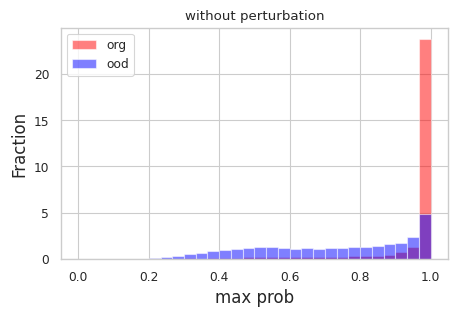

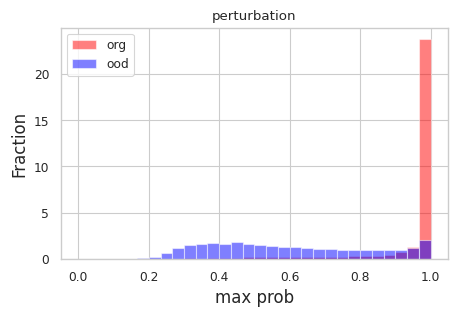

In [43]:
plot_density([probs, ood_probs], binrange=[0, 1], bins=30, title="without perturbation", xlabel="max prob")
plt.savefig('pngs/logits_hist.png', bbox_inches='tight')
plot_density([probs, ood_probs2], binrange=[0, 1], bins=30, title="perturbation", xlabel="max prob")
plt.savefig('pngs/logits_hist2.png', bbox_inches='tight')

### Compute feature density


In [33]:
logits, labels = gmm_evaluate(
    net,
    gaussians_model,
    test_loader,
    device=device,
    num_classes=num_classes,
    storage_device=device,
)
ood_logits, ood_labels = gmm_evaluate(
    net,
    gaussians_model,
    ood_test_loader,
    device=device,
    num_classes=num_classes,
    storage_device=device,
)

logits2, labels2 ,_,_= gmm_evaluate_with_perturbation(
    net,
    gaussians_model,
    test_loader,
    device=device,
    num_classes=num_classes,
    storage_device=device,
)
ood_logits2, ood_labels2,_,_ = gmm_evaluate_with_perturbation(
    net,
    gaussians_model,
    ood_test_loader,
    device=device,
    num_classes=num_classes,
    storage_device=device,
)

100%|██████████| 40/40 [00:17<00:00,  2.28it/s]


In [34]:
logp = logsumexp(logits).cpu().numpy()
logp2 = logsumexp(logits2).cpu().numpy()
ood_logp = logsumexp(ood_logits).cpu().numpy()
ood_logp2 = logsumexp(ood_logits2).cpu().numpy()

### Plot feature density


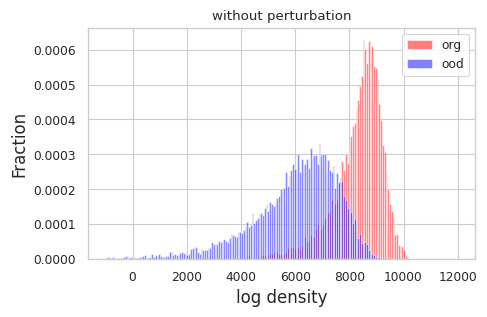

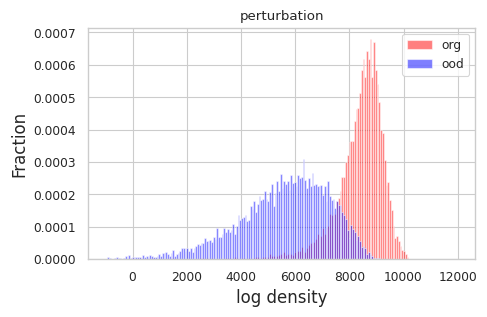

In [42]:
plot_density([logp, ood_logp], binrange=[-1000, 12000], bins=200, title="without perturbation", xlabel="log density")
plt.savefig('pngs/logdensity_hist.png', bbox_inches='tight')
plot_density([logp2, ood_logp2], binrange=[-1000, 12000], bins=200, title="perturbation", xlabel="log density")
plt.savefig('pngs/logdensity_hist2.png', bbox_inches='tight')

### Calibration Plot


In [47]:
from metrics.classification_metrics import test_classification_net
from metrics.calibration_metrics import reliability_plot
from utils.temperature_scaling import ModelWithTemperature

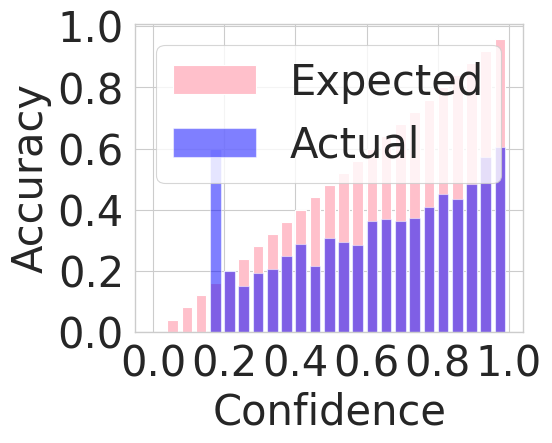

In [48]:
# Reliability plot
conf_matrix, accuracy, labels, predictions, confidences = test_classification_net(net, test_loader, device)
reliability_plot(confidences, predictions, labels, num_bins=25, model_name="resnet50")

Before temperature - NLL: 9.175, ECE: 0.328
Optimal temperature: 2.400
After temperature - NLL: 4.467, ECE: 0.109


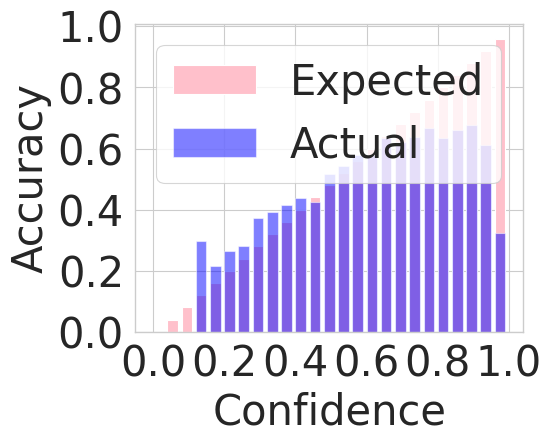

In [49]:
# Reliability plot for  post temp scaling
temp_model = ModelWithTemperature(net, device)
temp_model.set_temperature(test_loader)
conf_matrix, accuracy, labels, predictions, confidences = test_classification_net(temp_model, test_loader, device)
reliability_plot(confidences, predictions, labels, num_bins=25, model_name="resnet50")

In [50]:
print(conf_matrix)

[[379 121 137  79  34  15  37  21  88  89]
 [223 523  41  31   7   3  51   8   7 106]
 [130  66 226 193 102  20 201  23   8  31]
 [ 71  46  26 536  28  17 154  28  19  75]
 [ 34  34  22 204 391  11 226  28   6  44]
 [ 78  54  30 282  60 225 154  61   7  49]
 [ 52  32  10  79  15   6 783   4   2  17]
 [ 34  79  28 114  57  13  74 529   5  67]
 [122 129 110  74  11  14  53  18 412  57]
 [163 171  67  35   4   5  29   6   9 511]]
